In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

### Importing Dataset

In [3]:
#original dataset
data = pd.read_csv('India_Air_Quality_Data_For_TamilNadu.csv')
#get the column names
print(data.columns)

Index(['Stn Code', 'Sampling Date', 'State', 'City/Town/Village/Area',
       'Location of Monitoring Station', 'Agency', 'Type of Location', 'SO2',
       'NO2', 'RSPM/PM10', 'SPM'],
      dtype='object')


In [4]:
#extracted dataset for clustering cities based on pollution
df = pd.DataFrame(data, columns=['SO2','NO2', 'RSPM/PM10', 'SPM', 'City/Town/Village/Area'])
print(df)

         SO2        NO2   RSPM/PM10         SPM City/Town/Village/Area
0       9.60  17.166667   73.333333  149.666667                Chennai
1      11.15  20.283333   61.333333  150.333333                Chennai
2      12.45  20.516667   75.000000  114.666667                Chennai
3      10.75  18.183333  120.000000  197.666667                Chennai
4       9.78  17.320000   96.500000  216.000000                Chennai
...      ...        ...         ...         ...                    ...
12346  13.00  22.000000  118.000000         NaN                 Trichy
12347    NaN        NaN  104.000000         NaN                 Trichy
12348  14.00  24.000000  132.000000         NaN                 Trichy
12349  15.00  25.000000  147.000000         NaN                 Trichy
12350  15.00  24.000000  138.000000         NaN                 Trichy

[12351 rows x 5 columns]


### Pre-Processing

In [5]:
#droping NaN values of rows
df = df.dropna()

# To reset the indices 
df = df.reset_index(drop = True)
print(df)

        SO2        NO2   RSPM/PM10         SPM City/Town/Village/Area
0      9.60  17.166667   73.333333  149.666667                Chennai
1     11.15  20.283333   61.333333  150.333333                Chennai
2     12.45  20.516667   75.000000  114.666667                Chennai
3     10.75  18.183333  120.000000  197.666667                Chennai
4      9.78  17.320000   96.500000  216.000000                Chennai
...     ...        ...         ...         ...                    ...
1807  10.00  21.000000  119.000000   19.000000                 Trichy
1808  12.00  23.000000  134.000000   20.400000                 Trichy
1809  16.00  24.000000  138.000000   30.000000                 Trichy
1810  13.00  25.000000  134.000000   34.000000                 Trichy
1811  15.00  22.000000  145.000000   36.000000                 Trichy

[1812 rows x 5 columns]


In [10]:
#to remove the data which as less than 100 count
count = df.iloc[:,4].value_counts()
print('Count values of each unique cities:\n', count)
remove = count[count<100].index
for i in remove:
    df = df.drop(df[df['City/Town/Village/Area'] == i].index)
    
df = df.reset_index(drop = True)
print('\nFinalized Dataset for our model:\n', df)

Count values of each unique cities:
 Chennai        719
Coimbatore     348
Madurai        310
Thoothukudi    233
Salem          123
Name: City/Town/Village/Area, dtype: int64

Finalized Dataset for our model:
         SO2        NO2   RSPM/PM10         SPM City/Town/Village/Area
0      9.60  17.166667   73.333333  149.666667                Chennai
1     11.15  20.283333   61.333333  150.333333                Chennai
2     12.45  20.516667   75.000000  114.666667                Chennai
3     10.75  18.183333  120.000000  197.666667                Chennai
4      9.78  17.320000   96.500000  216.000000                Chennai
...     ...        ...         ...         ...                    ...
1728  12.00  14.000000   82.000000   15.000000                Chennai
1729  10.00  13.000000   66.000000   23.000000                Chennai
1730  13.00  17.000000   98.000000   33.000000                Chennai
1731  11.00  15.000000  200.000000  141.000000                Chennai
1732  11.00  19.0000

In [11]:
#assigning pollution data to X for DBSCAN clustering
X = df.iloc[:,:-1].values


In [12]:
#to know unique vales in city
print(df.iloc[:,4].unique())

['Chennai' 'Coimbatore' 'Madurai' 'Salem' 'Thoothukudi']


In [13]:
#replacing citites name to number for ease computation (for the machine to understand)
labels_true = df.iloc[:,4].replace({'Chennai':0, 'Coimbatore':1, 'Madurai':2, 'Salem':3, 'Thoothukudi':4})
print(labels_true.unique())

[0 1 2 3 4]


In [14]:
#converting to array
labels_true = labels_true.values
labels_true


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [15]:
X = StandardScaler().fit_transform(X)


In [16]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=16).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 5
Estimated number of noise points: 1138
Homogeneity: 0.218
Completeness: 0.290
V-measure: 0.249
Adjusted Rand Index: 0.057
Adjusted Mutual Information: 0.245
Silhouette Coefficient: -0.077


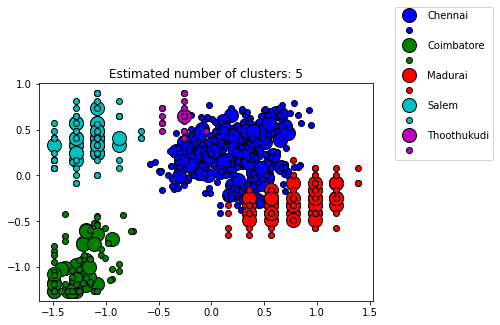

In [17]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels_true)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == 0:
        # Blue used for 0 that is Chennai.
        col = 'b'

    class_member_mask = (labels == k)
   
    if k == 1:
        # Green used for 1 that is Coimbatore.
        col = 'g'

    class_member_mask = (labels == k)
    
    if k == 2:
        # Red used for 2 that is Madurai.
        col = 'r'

    class_member_mask = (labels == k)
    
    if k == 3:
        # Cyan used for 3 that is Salem.
        col = 'c'

    class_member_mask = (labels == k)
    
    if k == 4:
        # Magenta used for 4 that is Thoothukudi.
        col = 'm'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.legend(['Chennai','', 'Coimbatore','','Madurai','', 'Salem','', 'Thoothukudi','',], loc='center left', bbox_to_anchor=(1.05, 1))
plt.show()

### Inference (with respect to the dataset):
        The Chennai city is heighest polluted city.
        The Thoothukudi city is least polluted city.